# Elo Merchant Category Recommendation - LightGBM
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

random.seed(1)
threshold = 0.5

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Merchants

In [4]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

334,696 records and 21 features in merchant set.


In [5]:
df_merch[:3]

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


In [6]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [7]:
df_merch[['category_1', 'category_2', 'category_4', 'most_recent_sales_range', 'most_recent_purchases_range']][:3]

,category_1,category_2,category_4,most_recent_sales_range,most_recent_purchases_range
merchant_id,,,,,
M_ID_838061e48c,0,1.0,0,0,0
M_ID_9339d880ad,0,1.0,0,0,0
M_ID_e726bbae1e,0,5.0,0,0,0


In [8]:
df_merch = reduce_mem_usage(df_merch)

Starting memory usage: 56.18 MB
Reduced memory usage: 21.39 MB (61.9% reduction)


In [9]:
df_merch = df_merch.groupby(df_merch.index).first()

## Train and test data

In [10]:
df_train = pd.read_csv("input/train.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
201,917 records and 6 features in train set.
123,623 records and 5 features in test set.


In [11]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988


In [12]:
df_train["year"] = df_train["first_active_month"].str.slice(0, 4)
df_train["year"] = df_train["year"].astype(int)
df_train["month"] = df_train["first_active_month"].str.slice(5, 7)
df_train["month"] = df_train["month"].astype(int)

In [13]:
df_test["year"] = df_test["first_active_month"].str.slice(0, 4)
df_test["year"] = df_test[df_test['first_active_month'].isnull() == False]["year"].astype('int8')
df_test["month"] = df_test["first_active_month"].str.slice(5, 7)
df_test["month"] = df_test[df_test['first_active_month'].isnull() == False]["month"].astype('int8')

In [14]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,2017,6
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,2016,8


In [15]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month
0,2017-04,C_ID_0ab67a22ab,3,3,1,-31.0,4.0
1,2017-01,C_ID_130fd0cbdd,2,3,0,-31.0,1.0
2,2017-08,C_ID_b709037bc5,5,1,1,-31.0,8.0


## Transactions

In [16]:
%%time
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv", index_col='card_id')
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
CPU times: user 7.23 s, sys: 1.22 s, total: 8.45 s
Wall time: 8.72 s


In [17]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv", index_col='card_id')
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.8% reduction)
CPU times: user 1min 31s, sys: 1min 14s, total: 2min 46s
Wall time: 3min 57s


In [18]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'Y': 1, 'N': 0})
df_new_trans['category_3'] = df_new_trans['category_3'].map({'C': 0, 'B': 1, 'A': 2})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [19]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'C': 0, 'B': 1, 'A': 2})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [20]:
df_new_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_415bb3a509,1,107,0,1,1.0,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19,2018,3,11,14,10,6,1
C_ID_415bb3a509,1,140,0,1,1.0,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19,2018,3,19,18,12,0,1
C_ID_415bb3a509,1,330,0,1,1.0,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14,2018,4,26,14,17,3,2


In [21]:
df_hist_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_4e6213e9bc,1,88,0,0,2.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,15,25,6,2
C_ID_4e6213e9bc,1,88,0,0,2.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,12,28,5,3
C_ID_4e6213e9bc,1,88,0,0,2.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,22,32,2,3


## Aggregation

In [22]:
def aggregate_transactions(df, prefix):  
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'category_1': ['sum', 'mean'],
        'category_2': ['sum', 'mean'],
        'category_3': ['sum', 'mean'],

        'city_id': ['nunique'],

        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],

        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'month_lag': ['min', 'max', 'mean'],

        'state_id': ['nunique'],
        'subsector_id': ['nunique'],

        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_year': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_day': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_hour': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_weekofyear': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_dayofweek': ['mean', 'median', 'max', 'min', 'std']
    }
    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)

    df = (df_agg.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')

    return df_agg

In [23]:
df_new_trans = aggregate_transactions(df_new_trans, prefix='new_')

In [24]:
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 112.29 MB
Reduced memory usage: 30.42 MB (72.9% reduction)


In [25]:
df_new_trans.to_csv('input/trans_new_aggregated.csv')

In [26]:
df_hist_trans = aggregate_transactions(df_hist_trans, prefix='hist_')

In [27]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 129.15 MB
Reduced memory usage: 37.88 MB (70.7% reduction)


In [28]:
df_hist_trans.to_csv('input/trans_hist_aggregated.csv')

## Merging

In [29]:
df_hist_trans = pd.read_csv("input/trans_hist_aggregated.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 149.02 MB
Reduced memory usage: 36.63 MB (75.4% reduction)


In [30]:
df_new_trans = pd.read_csv("input/trans_new_aggregated.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 132.75 MB
Reduced memory usage: 29.32 MB (77.9% reduction)


Join the data of the merchants and the transactions to the training and test set.

In [31]:
%%time
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')

CPU times: user 2.17 s, sys: 15.6 ms, total: 2.19 s
Wall time: 2.46 s


In [32]:
%%time
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

CPU times: user 1.45 s, sys: 46.9 ms, total: 1.5 s
Wall time: 1.62 s


In [33]:
del df_hist_trans
del df_new_trans
gc.collect()

84

In [34]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,Unnamed: 0_x,hist_transactions_count,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,2017,6,186538,1,...,13.304688,13.0,17.0,10.0,2.304688,3.130859,4.0,6.0,0.0,2.029297
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,77733,1,...,9.000000,9.0,13.0,5.0,3.687500,1.500000,1.0,4.0,0.0,1.643555
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,2016,8,272262,1,...,17.000000,17.0,17.0,17.0,NaN,5.000000,5.0,5.0,5.0,NaN


In [35]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month,Unnamed: 0_x,hist_transactions_count,hist_authorized_flag_sum,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,2017-04,C_ID_0ab67a22ab,3,3,1,-31.0,4.0,13622,1,44,...,7.000000,7.0,9.0,5.0,2.000000,3.666016,4.0,5.0,2.0,1.527344
1,2017-01,C_ID_130fd0cbdd,2,3,0,-31.0,1.0,24152,1,77,...,12.445312,11.0,16.0,9.0,2.789062,3.000000,4.0,6.0,0.0,2.291016
2,2017-08,C_ID_b709037bc5,5,1,1,-31.0,8.0,232780,1,9,...,10.000000,10.0,11.0,9.0,1.414062,2.000000,2.0,3.0,1.0,1.414062


## Training

### LightGBM - all features
For more details click [here](https://lightgbm.readthedocs.io/en/latest/).

In [39]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)
df_train[features][:3]

,feature_1,feature_2,feature_3,year,month,Unnamed: 0_x,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,5,2,1,2017,6,186538,1,247,0.950195,0,...,13.304688,13.0,17.0,10.0,2.304688,3.130859,4.0,6.0,0.0,2.029297
1,4,1,0,2017,1,77733,1,339,0.968750,31,...,9.000000,9.0,13.0,5.0,3.687500,1.500000,1.0,4.0,0.0,1.643555
2,2,2,0,2016,8,272262,1,41,0.953613,0,...,17.000000,17.0,17.0,17.0,NaN,5.000000,5.0,5.0,5.0,NaN


In [40]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective':'regression',
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71587	valid_1's rmse: 3.79214
[200]	training's rmse: 3.63877	valid_1's rmse: 3.75104
[300]	training's rmse: 3.58535	valid_1's rmse: 3.73001
[400]	training's rmse: 3.54481	valid_1's rmse: 3.71797
[500]	training's rmse: 3.51015	valid_1's rmse: 3.71042
[600]	training's rmse: 3.4788	valid_1's rmse: 3.70509
[700]	training's rmse: 3.45241	valid_1's rmse: 3.70129
[800]	training's rmse: 3.42932	valid_1's rmse: 3.69876
[900]	training's rmse: 3.40825	valid_1's rmse: 3.69634
[1000]	training's rmse: 3.3888	valid_1's rmse: 3.6948
[1100]	training's rmse: 3.37049	valid_1's rmse: 3.69354
[1200]	training's rmse: 3.35325	valid_1's rmse: 3.69241
[1300]	training's rmse: 3.33685	valid_1's rmse: 3.69177
[1400]	training's rmse: 3.32151	valid_1's rmse: 3.69111
[1500]	training's rmse: 3.30687	valid_1's rmse: 3.69075
[1600]	training's rmse: 3.29337	valid_1's rmse: 3.69038
[1700]	training's rmse: 3.27951	valid_1's rm

In [41]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.6709642564387144


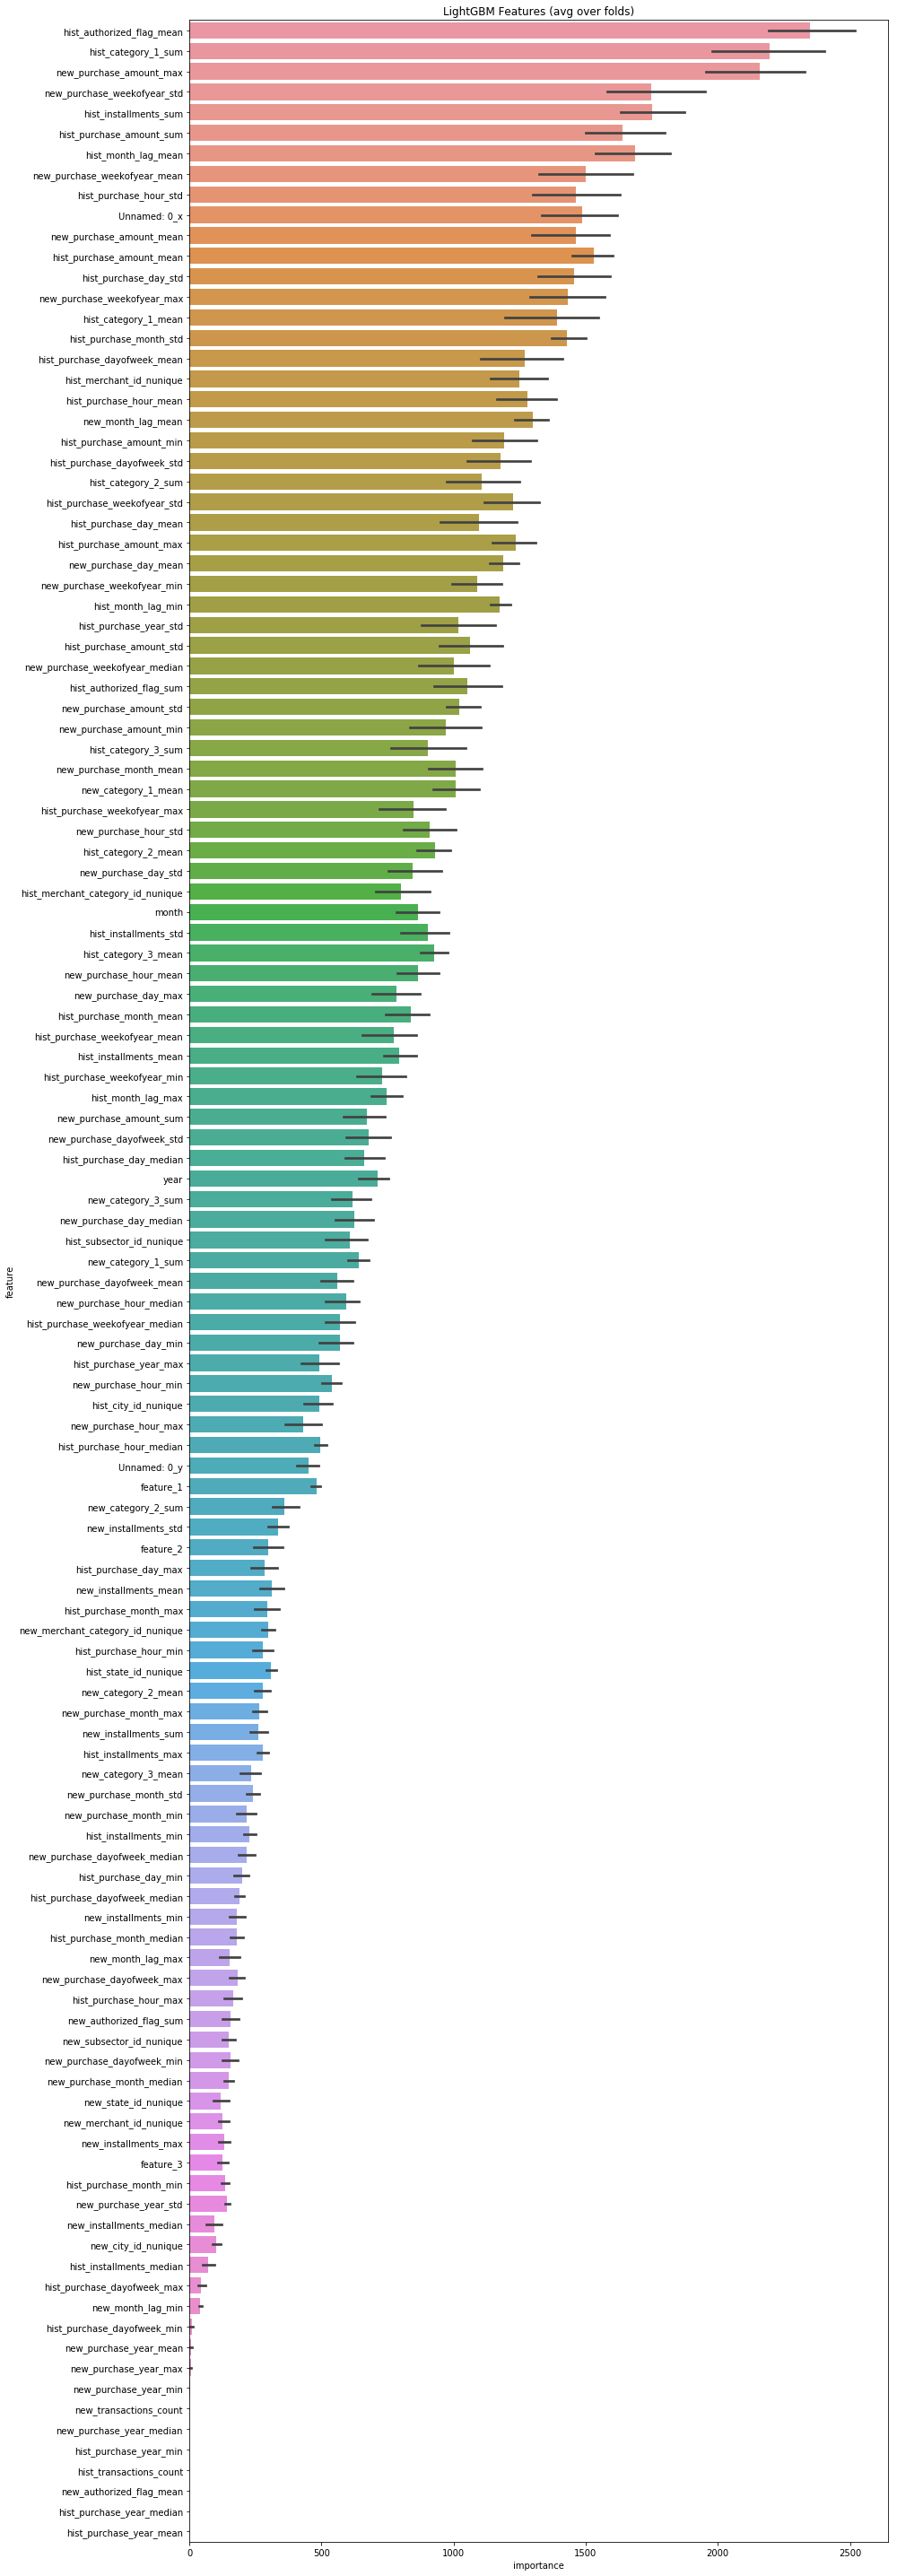

In [42]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [27]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

### LightGBM - importance more than 100

In [33]:
list(best_features[best_features['importance'] < 100]['feature'])

['feature_3',
 'hist_transactions_count',
 'hist_installments_median',
 'hist_purchase_year_mean',
 'hist_purchase_year_median',
 'hist_purchase_year_min',
 'hist_purchase_month_min',
 'hist_purchase_dayofweek_max',
 'hist_purchase_dayofweek_min',
 'new_transactions_count',
 'new_authorized_flag_sum',
 'new_authorized_flag_mean',
 'new_category_1_sum',
 'new_category_1_mean',
 'new_city_id_nunique',
 'new_installments_median',
 'new_month_lag_min',
 'new_purchase_year_mean',
 'new_purchase_year_median',
 'new_purchase_year_max',
 'new_purchase_year_min',
 'hist_transactions_count',
 'hist_installments_median',
 'hist_purchase_year_mean',
 'hist_purchase_year_median',
 'hist_purchase_year_min',
 'hist_purchase_dayofweek_max',
 'hist_purchase_dayofweek_min',
 'new_transactions_count',
 'new_authorized_flag_sum',
 'new_authorized_flag_mean',
 'new_category_1_sum',
 'new_category_1_mean',
 'new_month_lag_min',
 'new_purchase_year_mean',
 'new_purchase_year_median',
 'new_purchase_year_max'

In [37]:
cols = ['Unnamed: 0_x', 'feature_3', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_month_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_city_id_nunique', 'new_installments_median', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_installments_median', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min']

df_train.drop(columns=cols, inplace=True, axis=1)
df_test.drop(columns=cols, inplace=True, axis=1)

In [39]:
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

,feature_1,feature_2,year,month,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_sum,hist_category_2_mean,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,5,2,2017,6,247,0.950195,0,0.000000,272.0,1.045898,...,13.304688,13.0,17.0,10.0,2.304688,3.130859,4.0,6.0,0.0,2.029297
1,4,1,2017,1,339,0.968750,31,0.088562,319.0,1.000000,...,9.000000,9.0,13.0,5.0,3.687500,1.500000,1.0,4.0,0.0,1.643555
2,2,2,2016,8,41,0.953613,0,0.000000,199.0,4.628906,...,17.000000,17.0,17.0,17.0,NaN,5.000000,5.0,5.0,5.0,NaN


In [40]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71697	valid_1's rmse: 3.79304
[200]	training's rmse: 3.64031	valid_1's rmse: 3.75297
[300]	training's rmse: 3.58774	valid_1's rmse: 3.73277
[400]	training's rmse: 3.5472	valid_1's rmse: 3.72208
[500]	training's rmse: 3.51293	valid_1's rmse: 3.71484
[600]	training's rmse: 3.4824	valid_1's rmse: 3.70965
[700]	training's rmse: 3.45613	valid_1's rmse: 3.70664
[800]	training's rmse: 3.43397	valid_1's rmse: 3.7044
[900]	training's rmse: 3.41278	valid_1's rmse: 3.70254
[1000]	training's rmse: 3.39347	valid_1's rmse: 3.70121
[1100]	training's rmse: 3.37517	valid_1's rmse: 3.70046
[1200]	training's rmse: 3.35869	valid_1's rmse: 3.69963
[1300]	training's rmse: 3.34272	valid_1's rmse: 3.69925
[1400]	training's rmse: 3.32774	valid_1's rmse: 3.69884
[1500]	training's rmse: 3.31291	valid_1's rmse: 3.69868
[1600]	training's rmse: 3.29899	valid_1's rmse: 3.69852
[1700]	training's rmse: 3.28489	valid_1's rm

In [41]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.6755635261330393


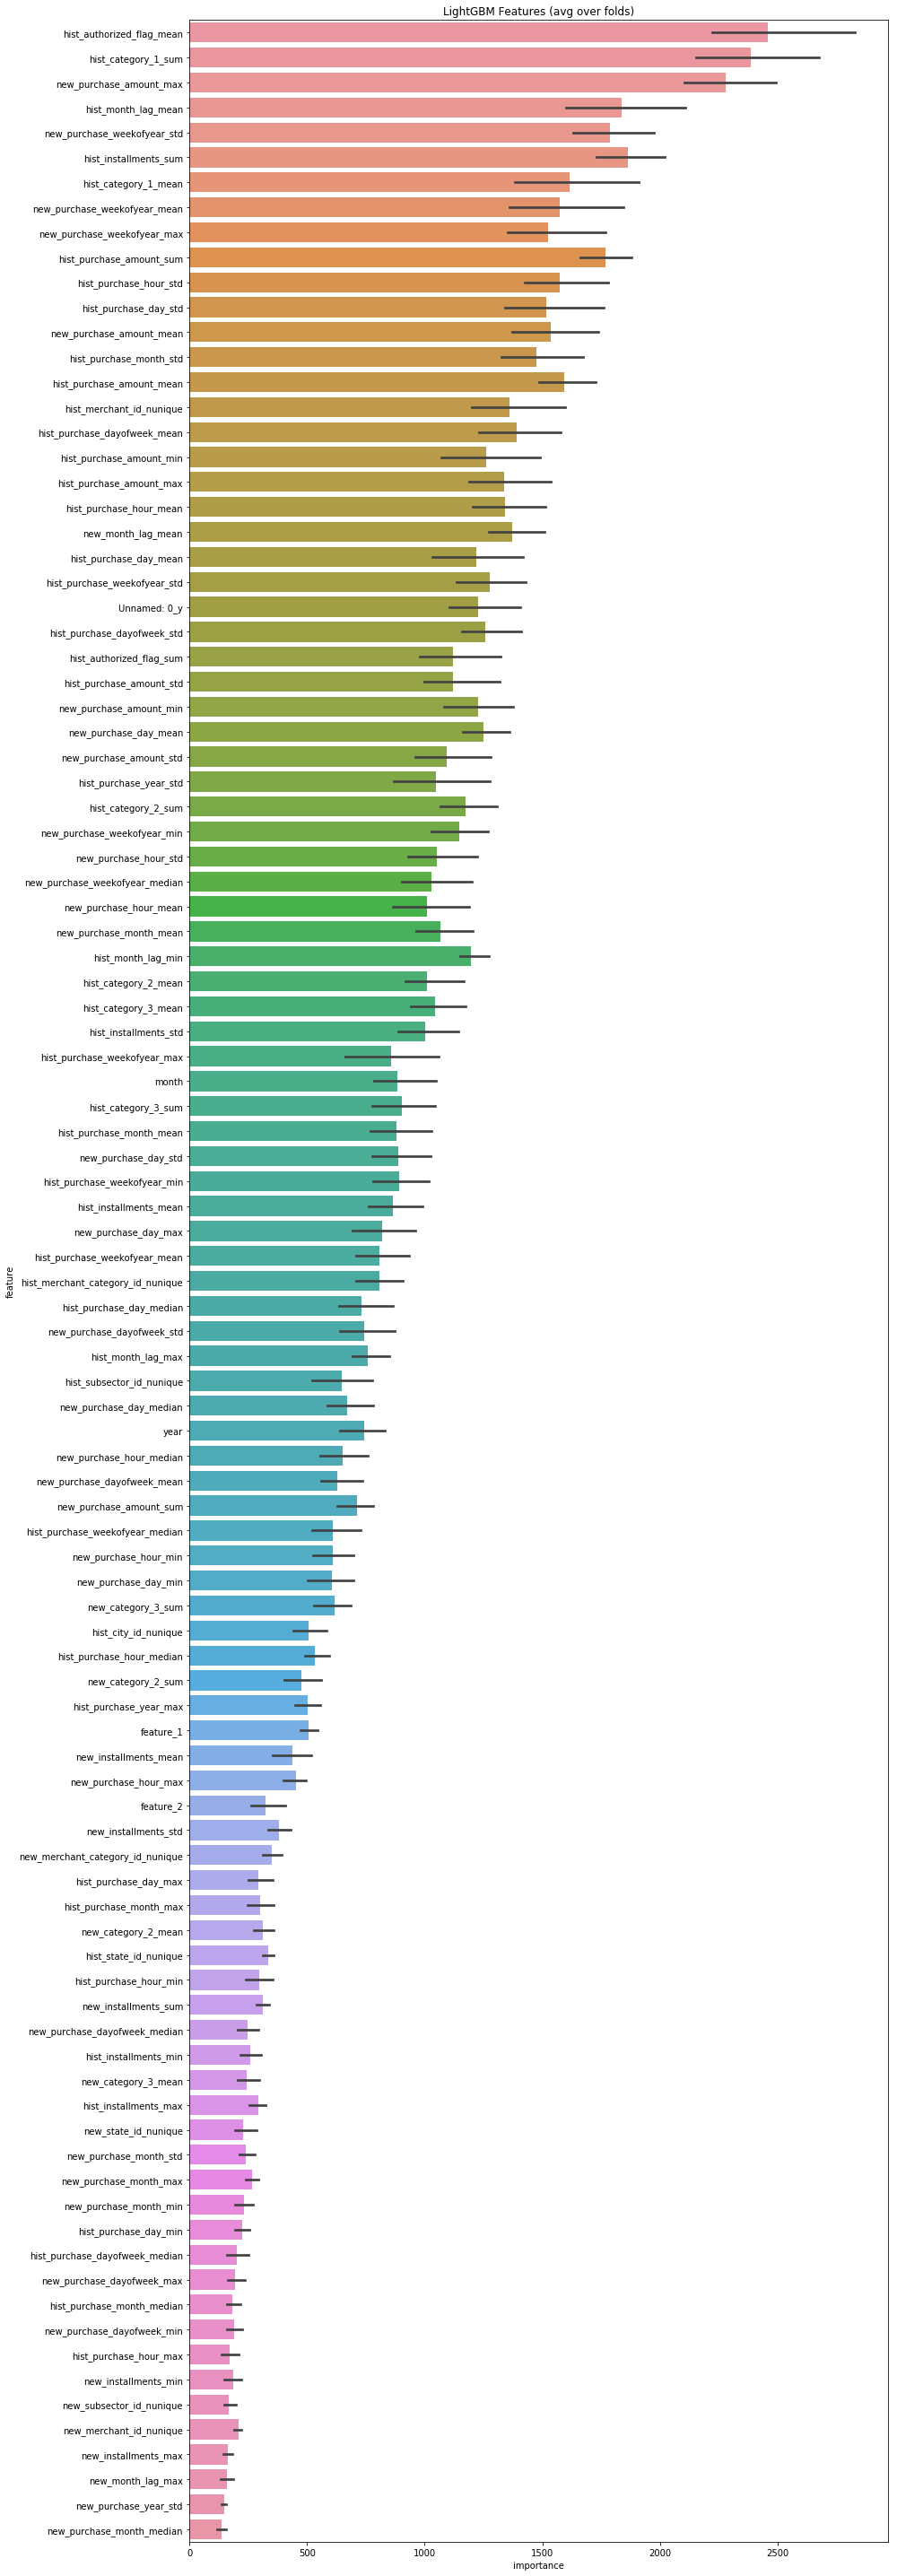

In [42]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [43]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

### LightGBM - importance more than 200

In [43]:
cols = best_features[best_features['importance'] < 200]['feature']

df_train.drop(columns=cols, inplace=True, axis=1)
df_test.drop(columns=cols, inplace=True, axis=1)

In [44]:
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

In [45]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71704	valid_1's rmse: 3.79317
[200]	training's rmse: 3.63995	valid_1's rmse: 3.75216
[300]	training's rmse: 3.58719	valid_1's rmse: 3.73115
[400]	training's rmse: 3.54646	valid_1's rmse: 3.71843
[500]	training's rmse: 3.5119	valid_1's rmse: 3.71068
[600]	training's rmse: 3.48144	valid_1's rmse: 3.7046
[700]	training's rmse: 3.45571	valid_1's rmse: 3.70119
[800]	training's rmse: 3.43263	valid_1's rmse: 3.69885
[900]	training's rmse: 3.41187	valid_1's rmse: 3.69708
[1000]	training's rmse: 3.39248	valid_1's rmse: 3.69613
[1100]	training's rmse: 3.37446	valid_1's rmse: 3.69516
[1200]	training's rmse: 3.35776	valid_1's rmse: 3.6941
[1300]	training's rmse: 3.34153	valid_1's rmse: 3.69336
[1400]	training's rmse: 3.32636	valid_1's rmse: 3.69295
[1500]	training's rmse: 3.3116	valid_1's rmse: 3.69263
[1600]	training's rmse: 3.29755	valid_1's rmse: 3.6924
[1700]	training's rmse: 3.28353	valid_1's rmse

In [46]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.6714034977902954


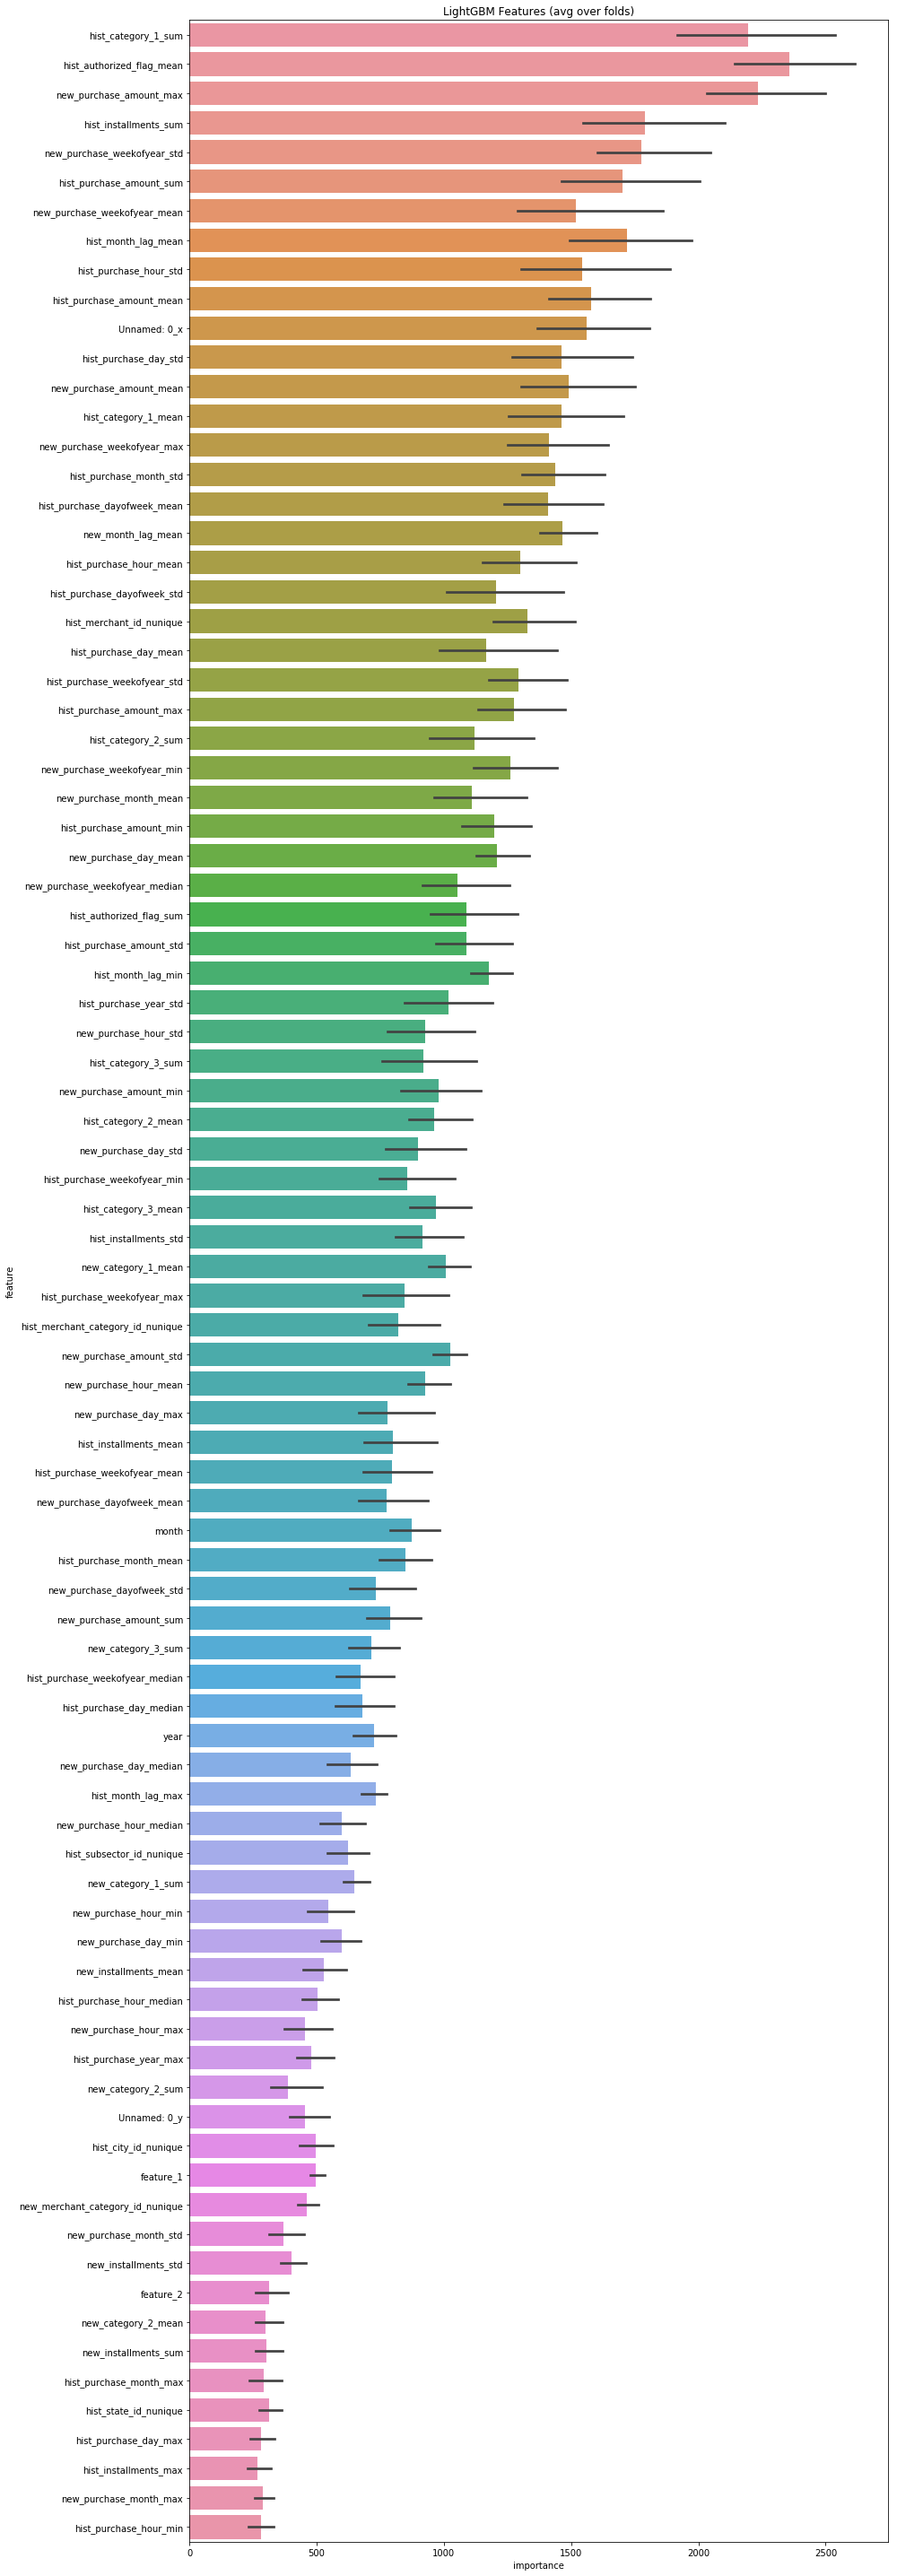

In [47]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [48]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)